In [1]:
import s3fs
import pyarrow.dataset as ds
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your S3 bucket URLs
s3_parquet_url_1_0 = "s3://logan-pub/stats/logan-seqstats.parquet"
s3_parquet_url_1_1 = "s3://serratus-rayan/logan-seqstats/logan-contigs-v1.1.parquet"

# Create an S3 filesystem instance
fs = s3fs.S3FileSystem(anon=True, client_kwargs={'region_name': 'us-east-1'})

import awswrangler as wr
contigs_1_0 = wr.s3.read_parquet(path=s3_parquet_url_1_0)
contigs_1_1 = wr.s3.read_parquet(path=s3_parquet_url_1_1)


# Add method labels
contigs_1_0 = contigs_1_0.assign(method="v1.0 contigs")
contigs_1_1 = contigs_1_1.assign(method="v1.1 contigs")

# Combine datasets
combined_contigs = pd.concat([contigs_1_0, contigs_1_1], ignore_index=True)


In [2]:
combined_contigs

accession  contigs_after_compression  contigs_before_compression  \
0         SRR21213796                       <NA>                        <NA>   
1          SRR7091786                       <NA>                        <NA>   
2         SRR24068156                       <NA>                        <NA>   
3          SRR7057089                       <NA>                        <NA>   
4          SRR8503097                       <NA>                        <NA>   
...               ...                        ...                         ...   
54058134  SRR13421778                       <NA>                        <NA>   
54058135  SRR13278941                       <NA>                        <NA>   
54058136   ERR7901830                       <NA>                        <NA>   
54058137   SRR7413126                       <NA>                        <NA>   
54058138  SRR19862278                       <NA>                        <NA>   

         size_contigs_after_compression size_contigs_before_compression  \
0                                 11134                           37990   
1                               2502846                         9092276   
2                                149813                          747203   
3                                 80962                          396891   
4                              58433742                       215066750   
...                                 ...                             ...   
54058134                           6335                           32921   
54058135                           3631                           15894   
54058136                       36809645                       130466319   
54058137                        1131753                         5471118   
54058138                       20980669                        74243161   

          unitigs_after_compression  unitigs_before_compression  \
0                              <NA>                        <NA>   
1                              <NA>                        <NA>   
2                              <NA>                        <NA>   
3                              <NA>                        <NA>   
4                              <NA>                        <NA>   
...                             ...                         ...   
54058134                       <NA>                        <NA>   
54058135                       <NA>                        <NA>   
54058136                       <NA>                        <NA>   
54058137                       <NA>                        <NA>   
54058138                       <NA>                        <NA>   

          size_unitigs_after_compression  size_unitigs_before_compression  \
0                                  38131                           179535   
1                               43612385                        174252807   
2                                1456727                          7240423   
3                                 951351                          4799949   
4                              292529881                       1127150460   
...                                  ...                              ...   
54058134                            <NA>                             <NA>   
54058135                            <NA>                             <NA>   
54058136                            <NA>                             <NA>   
54058137                            <NA>                             <NA>   
54058138                            <NA>                             <NA>   

         seqstats_contigs_n50 seqstats_contigs_nbseq seqstats_contigs_maxlen  \
0                        1536                    102                    2952   
1                         332                  39546                    3529   
2                          38                   7112                     423   
3                          42                   3694                     403   
4                   

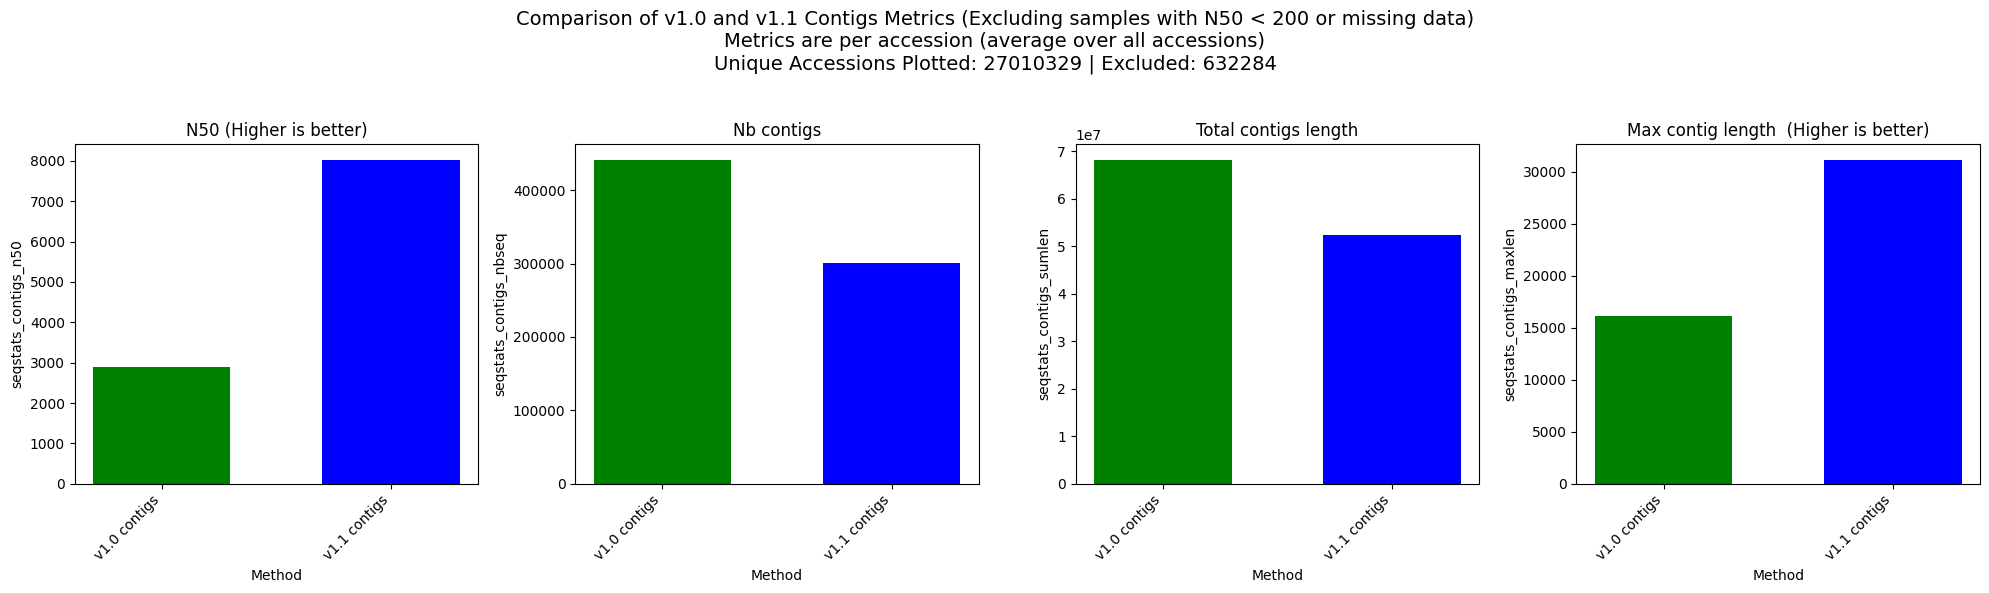

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine datasets
combined_contigs = pd.concat([contigs_1_0, contigs_1_1], ignore_index=True)

# Identify the column that holds the accession/sample ID
# (Assume it's named 'accession'; adjust if your column name is different)
accession_col = 'accession'

# Count the original number of unique accessions
original_accessions = combined_contigs[accession_col].nunique()

# Step 0: Define metrics to plot
metrics_to_plot = [
    'seqstats_contigs_n50',
    'seqstats_contigs_nbseq',
    'seqstats_contigs_sumlen',
    'seqstats_contigs_maxlen'
]

# Convert these columns to numeric and coerce invalid entries to NaN
for metric in metrics_to_plot:
    combined_contigs[metric] = pd.to_numeric(combined_contigs[metric], errors='coerce')

# Drop rows that have NaN in any of the four metrics
combined_contigs = combined_contigs.dropna(subset=metrics_to_plot)

# Step 1: Filter out rows where N50 is less than 200
filtered_contigs = combined_contigs[combined_contigs['seqstats_contigs_n50'] >= 200]

# Now count the filtered unique accessions
filtered_accessions = combined_contigs[accession_col].nunique()
excluded_accessions = original_accessions - filtered_accessions

# Step 2: Group by method and calculate mean stats
mean_stats = filtered_contigs.groupby('method')[metrics_to_plot].mean().reset_index()

# Step 3: Define labels for metrics
metric_labels = {
    'seqstats_contigs_n50':   'N50 (Higher is better)',
    'seqstats_contigs_nbseq': 'Nb contigs',
    'seqstats_contigs_sumlen': 'Total contigs length',
    'seqstats_contigs_maxlen': 'Max contig length (Higher is better)'
}

# Step 4: Create plots
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 6), sharey=False)

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    # Define bar colors based on method
    bar_colors = ['green' if method == 'v1.0 contigs' else 'blue' for method in mean_stats['method']]
    
    ax.bar(mean_stats['method'], mean_stats[metric], color=bar_colors, width=0.6)
    ax.set_title(metric_labels[metric])
    ax.set_xlabel('Method')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(mean_stats['method'])))
    ax.set_xticklabels(mean_stats['method'], rotation=45, ha='right')

# Update the figure title to show how many unique accessions remain vs. excluded
title_str = (
    f"Comparison of v1.0 and v1.1 Contigs Metrics (Excluding samples with N50 < 200 or missing data)\n"
    "Metrics are per accession (average over all accessions)\n"
    f"Unique Accessions considered: {filtered_accessions} | Excluded: {excluded_accessions}"
)
fig.suptitle(title_str, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [3]:
# Check if the column exists
column = 'seqstats_contigs_nbseq'
#column = 'seqstats_contigs_n50'
column = 'accession'
if column in combined_contigs.columns:
    # Identify rows with missing or NaN values in 'seqstats_contigs_nbseq'
    missing_nbseq_rows = combined_contigs[combined_contigs[column].isna()]
    # Count how many rows are missing
    print(f"Number of rows with missing '{column}':", missing_nbseq_rows.shape[0])

    # Determine if these rows are from v1.0 or v1.1
    print("Counts of methods for missing rows:")
    print(missing_nbseq_rows['method'].value_counts())

    # Print a few rows
    print(f"Sample of rows with missing '{column}':")
    print(missing_nbseq_rows.head())
else:
    print(f"Column '{column}' does not exist in the DataFrame.")


Number of rows with missing 'accession': 0
Counts of methods for missing rows:
Series([], Name: method, dtype: int64)
Sample of rows with missing 'accession':
Empty DataFrame
Columns: [method, accession, seqstats_contigs_n50, seqstats_contigs_nbseq, seqstats_contigs_sumlen, seqstats_contigs_maxlen]
Index: []


In [2]:
columns_to_keep = ['method','accession',
                   'seqstats_contigs_n50',
                   'seqstats_contigs_nbseq',
                   'seqstats_contigs_sumlen',
                   'seqstats_contigs_maxlen']

contigs_1_0 = contigs_1_0[columns_to_keep].copy()
contigs_1_1 = contigs_1_1[columns_to_keep].copy()

combined_contigs = pd.concat([contigs_1_0, contigs_1_1], ignore_index=True)
